Q-LEARNING: PENGUIN FISH CATCHING
DRP Project - University of Michigan
VERSION 1: STATIONARY FISH

Initializing environment and agent...
Environment: 6x6 grid with 3 fish
Fish behavior: STATIONARY (do not move)
Actions: ['Stay', 'Up', 'Down', 'Left', 'Right']
Rewards: +10 per fish caught, -0.1 per step
Max steps per episode: 200

Training agent...

Episode 200/2000 | Avg Reward: 7.97 | Avg Steps: 155.3 | Avg Fish: 2.35 | Epsilon: 0.548
Episode 400/2000 | Avg Reward: 6.22 | Avg Steps: 157.3 | Avg Fish: 2.19 | Epsilon: 0.301
Episode 600/2000 | Avg Reward: 2.24 | Avg Steps: 170.6 | Avg Fish: 1.93 | Epsilon: 0.165
Episode 800/2000 | Avg Reward: 2.60 | Avg Steps: 169.5 | Avg Fish: 1.96 | Epsilon: 0.090
Episode 1000/2000 | Avg Reward: 1.61 | Avg Steps: 171.9 | Avg Fish: 1.88 | Epsilon: 0.050
Episode 1200/2000 | Avg Reward: 1.07 | Avg Steps: 174.3 | Avg Fish: 1.85 | Epsilon: 0.027
Episode 1400/2000 | Avg Reward: 1.34 | Avg Steps: 171.6 | Avg Fish: 1.85 | Epsilon: 0.015
Episode 1600/2000 | Avg

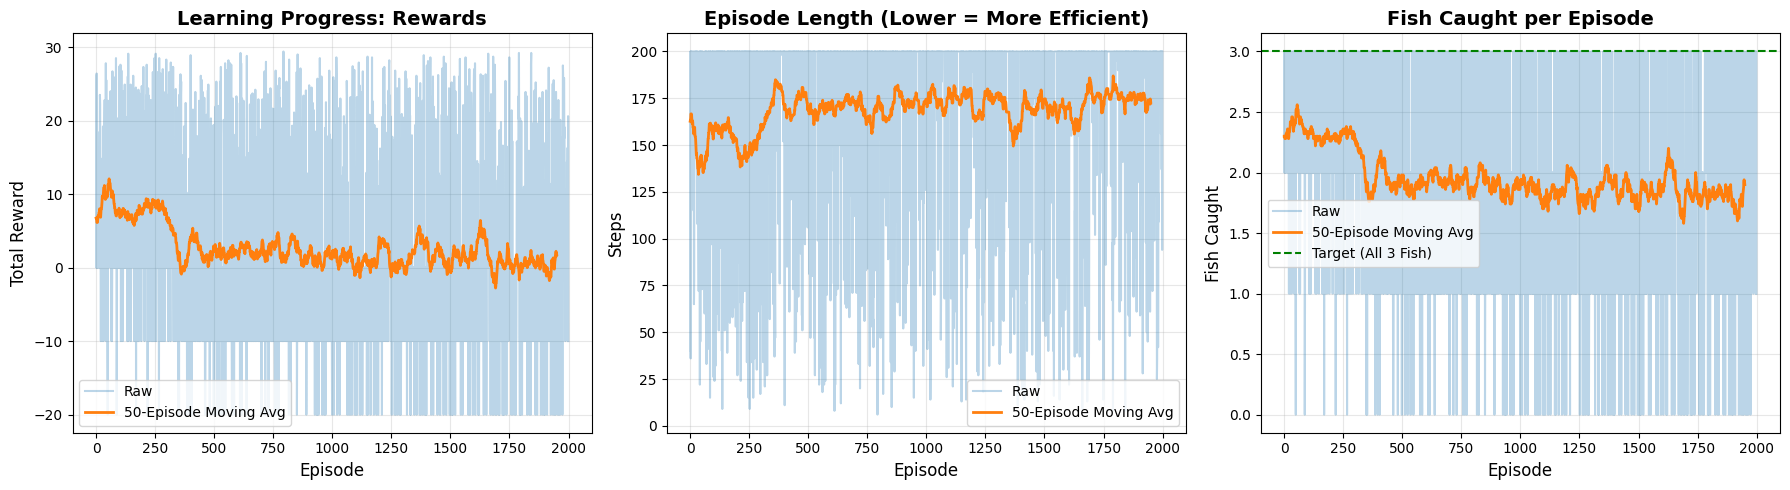


Testing trained agent...
  Test  1: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test  2: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test  3: Reward = -10.0 | Steps = 200 | Fish = 1/3
  Test  4: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test  5: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test  6: Reward = -10.0 | Steps = 200 | Fish = 1/3
  Test  7: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test  8: Reward = -10.0 | Steps = 200 | Fish = 1/3
  Test  9: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 10: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 11: Reward = -10.0 | Steps = 200 | Fish = 1/3
  Test 12: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 13: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 14: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 15: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 16: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 17: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 18: Reward = -20.0 | Steps = 200 | Fish = 0/3
  Test 19: Reward = 

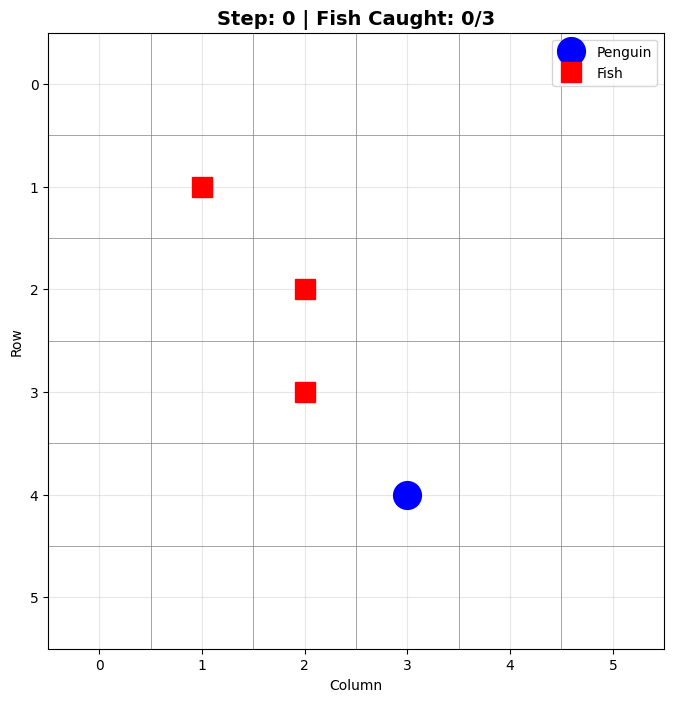


Visualization steps:

Episode complete! Total steps: 200, Total fish: 0/3

ALL DONE! Ready for presentation.


In [ ]:
"""
Reinforcement Learning: Q-Learning for Penguin Fish Catching
DRP Project - University of Michigan Math Department

Version 1: STATIONARY FISH (Simplified Learning Problem)
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import HTML
import random
from collections import defaultdict

class FishCatchingEnvironment:
    """
    Environment for the penguin fish-catching Q-learning problem.

    VERSION 1: STATIONARY FISH
    - Fish do not move (remain at initial positions)
    - Episode ends when all fish are caught
    - Negative reward per step incentivizes efficiency

    Grid: nxn grid
    Penguin: Controlled by our Q-learning agent
    Fish: Stationary targets at fixed positions
    Goal: Penguin catches all fish in minimum steps
    """

    def __init__(self, grid_size=6, num_fish=3, max_steps=200):
        self.grid_size = grid_size
        self.num_fish = num_fish
        self.max_steps = max_steps

        # Store initial fish positions (will be set in reset())
        self.initial_fish_positions = []
        self.reset()

        # Actions: 0=stay, 1=up, 2=down, 3=left, 4=right
        self.actions = [0, 1, 2, 3, 4]
        self.action_names = ['Stay', 'Up', 'Down', 'Left', 'Right']

    def reset(self):
        """Reset environment to initial state"""
        # Place penguin at random position
        self.penguin_pos = [np.random.randint(0, self.grid_size),
                           np.random.randint(0, self.grid_size)]

        # Place fish at random FIXED positions (different from penguin)
        self.initial_fish_positions = []
        for _ in range(self.num_fish):
            while True:
                fish_pos = [np.random.randint(0, self.grid_size),
                           np.random.randint(0, self.grid_size)]
                # Ensure fish doesn't start on penguin or another fish
                if (fish_pos != self.penguin_pos and
                    fish_pos not in self.initial_fish_positions):
                    self.initial_fish_positions.append(fish_pos)
                    break

        # Fish positions are STATIONARY - they stay at initial positions
        self.fish_positions = [pos.copy() for pos in self.initial_fish_positions]

        self.current_step = 0
        self.fish_caught = 0
        return self.get_state()

    def get_state(self):
        """
        Return current state as a tuple.
        State = (penguin_row, penguin_col, fish1_alive, fish2_alive, fish3_alive)
        where fish_alive is 1 if fish still exists, 0 if caught

        This representation is more efficient than storing all fish positions
        since fish don't move - we only need to know which ones are left!
        """
        state = tuple(self.penguin_pos)

        # For each initial fish position, check if it's still in fish_positions
        for initial_pos in self.initial_fish_positions:
            if initial_pos in self.fish_positions:
                state += (1,)  # Fish still alive
            else:
                state += (0,)  # Fish caught

        return state

    def move_entity(self, position, action):
        """
        Move an entity (penguin) based on action.
        Returns new position within grid bounds.
        """
        new_pos = position.copy()

        if action == 1:  # Up
            new_pos[0] = max(0, position[0] - 1)
        elif action == 2:  # Down
            new_pos[0] = min(self.grid_size - 1, position[0] + 1)
        elif action == 3:  # Left
            new_pos[1] = max(0, position[1] - 1)
        elif action == 4:  # Right
            new_pos[1] = min(self.grid_size - 1, position[1] + 1)
        # action == 0 means stay (no change)

        return new_pos

    def step(self, action):
        """
        Execute one time step.
        1. Move penguin based on action
        2. Fish DO NOT MOVE (stationary)
        3. Check for catches
        4. Apply step penalty
        5. Return (new_state, reward, done)
        """
        # Move penguin
        self.penguin_pos = self.move_entity(self.penguin_pos, action)

        # Fish remain stationary (no movement)

        # Check for catches and remove caught fish
        reward = -0.1  # Small step penalty to encourage efficiency
        fish_to_remove = []
        for i, fish_pos in enumerate(self.fish_positions):
            if self.penguin_pos == fish_pos:
                reward += 10  # Catch reward (+10 - 0.1 = +9.9 net for catching)
                fish_to_remove.append(i)
                self.fish_caught += 1

        # Remove caught fish (iterate backwards to maintain indices)
        for i in sorted(fish_to_remove, reverse=True):
            self.fish_positions.pop(i)

        self.current_step += 1

        # Episode is done if all fish caught or max steps reached
        done = (len(self.fish_positions) == 0) or (self.current_step >= self.max_steps)

        return self.get_state(), reward, done

    def render(self, ax=None):
        """Visualize the current state"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')

        # Draw grid
        for i in range(self.grid_size + 1):
            ax.axhline(i - 0.5, color='gray', linewidth=0.5)
            ax.axvline(i - 0.5, color='gray', linewidth=0.5)

        # Draw penguin (blue circle)
        ax.plot(self.penguin_pos[1], self.penguin_pos[0], 'bo', markersize=20, label='Penguin')

        # Draw fish (red squares) - still at their positions
        for fish_pos in self.fish_positions:
            ax.plot(fish_pos[1], fish_pos[0], 'rs', markersize=15, label='Fish' if fish_pos == self.fish_positions[0] else '')

        ax.set_title(f'Step: {self.current_step} | Fish Caught: {self.fish_caught}/{self.num_fish}',
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.invert_yaxis()  # Invert y-axis so (0,0) is top-left
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

        return ax


class QLearningAgent:
    """
    Q-Learning agent for the fish-catching problem.
    """

    def __init__(self, actions, learning_rate=0.1, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.actions = actions
        self.learning_rate = learning_rate  # Alpha
        self.discount_factor = discount_factor  # Gamma
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-table: dictionary with state as key, array of Q-values as value
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))

    def get_action(self, state, training=True):
        """
        Epsilon-greedy action selection.
        During training: explore with probability epsilon
        During testing: always exploit (greedy)
        """
        if training and np.random.random() < self.epsilon:
            # Explore: random action
            return np.random.choice(self.actions)
        else:
            # Exploit: best known action
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        """
        Q-learning update rule:
        Q(s,a) = Q(s,a) + alpha * [reward + gamma * max(Q(s',a')) - Q(s,a)]
        """
        current_q = self.q_table[state][action]

        if done:
            # If episode is done, there's no next state value
            target_q = reward
        else:
            # Bellman equation
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.discount_factor * max_next_q

        # Update Q-value
        self.q_table[state][action] = current_q + self.learning_rate * (target_q - current_q)

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


def train_agent(env, agent, num_episodes=1000, verbose_every=100):
    """
    Train the Q-learning agent.
    Returns history of rewards and steps per episode.
    """
    episode_rewards = []
    episode_steps = []
    episode_fish_caught = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Agent selects action
            action = agent.get_action(state, training=True)

            # Environment steps
            next_state, reward, done = env.step(action)

            # Agent learns
            agent.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

        # Decay exploration rate
        agent.decay_epsilon()

        # Record statistics
        episode_rewards.append(total_reward)
        episode_steps.append(env.current_step)
        episode_fish_caught.append(env.fish_caught)

        # Verbose output
        if (episode + 1) % verbose_every == 0:
            avg_reward = np.mean(episode_rewards[-verbose_every:])
            avg_steps = np.mean(episode_steps[-verbose_every:])
            avg_fish = np.mean(episode_fish_caught[-verbose_every:])
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Steps: {avg_steps:.1f} | "
                  f"Avg Fish: {avg_fish:.2f} | "
                  f"Epsilon: {agent.epsilon:.3f}")

    return episode_rewards, episode_steps, episode_fish_caught


def plot_training_results(episode_rewards, episode_steps, episode_fish_caught):
    """
    Plot training statistics.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Smooth curves using moving average
    window = 50
    if len(episode_rewards) >= window:
        smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        smoothed_steps = np.convolve(episode_steps, np.ones(window)/window, mode='valid')
        smoothed_fish = np.convolve(episode_fish_caught, np.ones(window)/window, mode='valid')
    else:
        smoothed_rewards = episode_rewards
        smoothed_steps = episode_steps
        smoothed_fish = episode_fish_caught

    # Plot 1: Total Reward per Episode
    axes[0].plot(episode_rewards, alpha=0.3, label='Raw')
    axes[0].plot(smoothed_rewards, linewidth=2, label=f'{window}-Episode Moving Avg')
    axes[0].set_xlabel('Episode', fontsize=12)
    axes[0].set_ylabel('Total Reward', fontsize=12)
    axes[0].set_title('Learning Progress: Rewards', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Steps per Episode
    axes[1].plot(episode_steps, alpha=0.3, label='Raw')
    axes[1].plot(smoothed_steps, linewidth=2, label=f'{window}-Episode Moving Avg')
    axes[1].set_xlabel('Episode', fontsize=12)
    axes[1].set_ylabel('Steps', fontsize=12)
    axes[1].set_title('Episode Length (Lower = More Efficient)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Fish Caught per Episode
    axes[2].plot(episode_fish_caught, alpha=0.3, label='Raw')
    axes[2].plot(smoothed_fish, linewidth=2, label=f'{window}-Episode Moving Avg')
    axes[2].set_xlabel('Episode', fontsize=12)
    axes[2].set_ylabel('Fish Caught', fontsize=12)
    axes[2].set_title('Fish Caught per Episode', fontsize=14, fontweight='bold')
    axes[2].axhline(y=3, color='green', linestyle='--', label='Target (All 3 Fish)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("Q-LEARNING: PENGUIN FISH CATCHING")
    print("DRP Project - University of Michigan")
    print("VERSION 1: STATIONARY FISH")
    print("=" * 70)
    print()

    # Initialize environment and agent
    print("Initializing environment and agent...")
    env = FishCatchingEnvironment(grid_size=6, num_fish=3, max_steps=200)
    agent = QLearningAgent(
        actions=env.actions,
        learning_rate=0.15,
        discount_factor=0.99,  # Higher for long episodes
        epsilon=1.0,
        epsilon_decay=0.997,  # Slower decay
        epsilon_min=0.01
    )

    print(f"Environment: {env.grid_size}x{env.grid_size} grid with {env.num_fish} fish")
    print(f"Fish behavior: STATIONARY (do not move)")
    print(f"Actions: {env.action_names}")
    print(f"Rewards: +10 per fish caught, -0.1 per step")
    print(f"Max steps per episode: {env.max_steps}")
    print()

    # Train the agent
    print("Training agent...")
    print()
    num_episodes = 2000
    episode_rewards, episode_steps, episode_fish_caught = train_agent(
        env, agent, num_episodes=num_episodes, verbose_every=200
    )

    print()
    print("=" * 70)
    print("TRAINING COMPLETE!")
    print("=" * 70)
    print(f"Total episodes: {num_episodes}")
    print(f"Final epsilon: {agent.epsilon:.3f}")
    print(f"Q-table size: {len(agent.q_table)} states learned")
    print()

    # Analyze final performance
    final_100_rewards = episode_rewards[-100:]
    final_100_steps = episode_steps[-100:]
    final_100_fish = episode_fish_caught[-100:]

    print("FINAL 100 EPISODES STATISTICS:")
    print(f"  Average reward: {np.mean(final_100_rewards):.2f}")
    print(f"  Average steps: {np.mean(final_100_steps):.1f}")
    print(f"  Average fish caught: {np.mean(final_100_fish):.2f}/{env.num_fish}")
    print(f"  Success rate (all 3 fish): {100 * np.sum(np.array(final_100_fish) == 3) / 100:.1f}%")
    print()

    # Plot training results
    print("Plotting training results...")
    plot_training_results(episode_rewards, episode_steps, episode_fish_caught)

    # Test the trained agent
    print()
    print("Testing trained agent...")
    test_episodes = 20
    test_rewards = []
    test_steps = []
    test_fish_caught = []

    for i in range(test_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state, training=False)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

        test_rewards.append(total_reward)
        test_steps.append(env.current_step)
        test_fish_caught.append(env.fish_caught)
        print(f"  Test {i+1:2d}: Reward = {total_reward:5.1f} | Steps = {env.current_step:3d} | Fish = {env.fish_caught}/{env.num_fish}")

    print()
    print("TEST RESULTS:")
    print(f"  Average reward: {np.mean(test_rewards):.2f}")
    print(f"  Average steps: {np.mean(test_steps):.1f}")
    print(f"  Average fish caught: {np.mean(test_fish_caught):.2f}/{env.num_fish}")
    print(f"  Success rate (all 3 fish): {100 * np.sum(np.array(test_fish_caught) == 3) / 20:.1f}%")
    print()

    # Visualize one episode
    print("Visualizing one episode with trained agent...")
    state = env.reset()
    done = False

    fig, ax = plt.subplots(figsize=(8, 8))

    # Show initial state
    env.render(ax)
    plt.pause(0.5)

    print("\nVisualization steps:")
    step = 0
    while not done:
        action = agent.get_action(state, training=False)
        next_state, reward, done = env.step(action)

        env.render(ax)
        plt.pause(0.3)

        if reward > 0:
            print(f"  Step {step}: CAUGHT A FISH! (Action: {env.action_names[action]}, Reward: {reward})")

        state = next_state
        step += 1

    print(f"\nEpisode complete! Total steps: {env.current_step}, Total fish: {env.fish_caught}/{env.num_fish}")
    plt.show()

    print()
    print("=" * 70)
    print("ALL DONE! Ready for presentation.")
    print("=" * 70)